In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [3]:
raw_df = pd.read_csv('heart.csv')

In [4]:
raw_df.shape

(918, 12)

In [5]:
raw_df.columns = raw_df.columns.str.lower()

In [6]:
raw_df.columns 

Index(['age', 'sex', 'chestpaintype', 'restingbp', 'cholesterol', 'fastingbs',
       'restingecg', 'maxhr', 'exerciseangina', 'oldpeak', 'st_slope',
       'heartdisease'],
      dtype='object')

In [7]:
raw_df.isnull().sum()

age               0
sex               0
chestpaintype     0
restingbp         0
cholesterol       0
fastingbs         0
restingecg        0
maxhr             0
exerciseangina    0
oldpeak           0
st_slope          0
heartdisease      0
dtype: int64

In [8]:
raw_df.heartdisease.value_counts(normalize=True)

heartdisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64

In [9]:
raw_df.heartdisease.mean()

0.5533769063180828

In [10]:
raw_df.nunique()

age                50
sex                 2
chestpaintype       4
restingbp          67
cholesterol       222
fastingbs           2
restingecg          3
maxhr             119
exerciseangina      2
oldpeak            53
st_slope            3
heartdisease        2
dtype: int64

In [11]:
raw_df.age.value_counts()

age
54    51
58    42
55    41
56    38
57    38
52    36
51    35
59    35
62    35
53    33
60    32
48    31
61    31
63    30
50    25
46    24
41    24
43    24
64    22
65    21
49    21
47    19
44    19
42    18
45    18
38    16
67    15
39    15
66    13
69    13
40    13
35    11
37    11
68    10
34     7
74     7
70     7
36     6
71     5
32     5
72     4
29     3
75     3
33     2
77     2
76     2
31     2
30     1
28     1
73     1
Name: count, dtype: int64

# Feature Analysis 

In [12]:
df_full_train, df_test = train_test_split(raw_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [13]:
len(df_train), len(df_val), len(df_test)

(550, 184, 184)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.heartdisease .values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

del df_train['heartdisease']
del df_val['heartdisease']
del df_test['heartdisease']

In [16]:
df_full_train.head(5)

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
852,43,M,ASY,120,177,0,LVH,120,Y,2.5,Flat,1
121,52,F,NAP,125,272,0,Normal,139,N,0.0,Up,0
664,65,F,ASY,150,225,0,LVH,114,N,1.0,Flat,1
187,41,M,ASY,120,237,1,Normal,138,Y,1.0,Flat,1
108,50,M,ASY,140,129,0,Normal,135,N,0.0,Up,0


In [17]:
df_full_train.heartdisease.value_counts()

heartdisease
1    398
0    336
Name: count, dtype: int64

In [18]:
mutual_col = list(df_train.columns)
mutual_col

['age',
 'sex',
 'chestpaintype',
 'restingbp',
 'cholesterol',
 'fastingbs',
 'restingecg',
 'maxhr',
 'exerciseangina',
 'oldpeak',
 'st_slope']

In [19]:
mutual_scores = []
for c in  df_full_train[mutual_col].columns: 
    score = round(mutual_info_score(df_full_train.heartdisease,df_full_train[c]),3)
    mutual_scores.append(score)
    print(f"mutual score for {c} is {score}")

mutual score for age is 0.087
mutual score for sex is 0.046
mutual score for chestpaintype is 0.152
mutual score for restingbp is 0.071
mutual score for cholesterol is 0.26
mutual score for fastingbs is 0.031
mutual score for restingecg is 0.007
mutual score for maxhr is 0.172
mutual score for exerciseangina is 0.123
mutual score for oldpeak is 0.132
mutual score for st_slope is 0.184


C:\Users\mulin\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


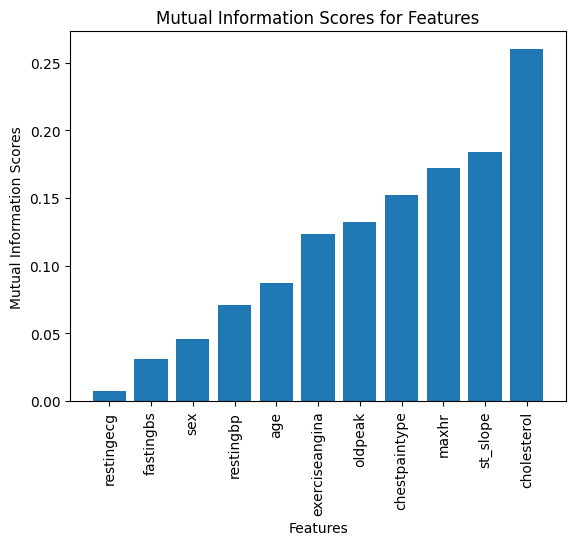

In [20]:
import matplotlib.pyplot as plt

sorted_mutual_scores, sorted_mutual_col_names = zip(*sorted(zip(mutual_scores, mutual_col)))
plt.bar(sorted_mutual_col_names, sorted_mutual_scores)
plt.xlabel("Features")
plt.ylabel("Mutual Information Scores")
plt.title("Mutual Information Scores for Features")
plt.xticks(rotation='vertical')
plt.show()

# Feature importance: Heartdisease rate and risk ratio

In [21]:
categorical_columns = list(df_full_train.dtypes[df_full_train.dtypes == 'object'].index)
categorical_columns

['sex', 'chestpaintype', 'restingecg', 'exerciseangina', 'st_slope']

In [22]:
for column in categorical_columns:
    unique_categories = df_full_train[column].unique() # this is important
    print(f"Heart disease rate for {column}:")
    for category in unique_categories:
        mean = df_full_train[df_full_train[column] == category].heartdisease.mean()
        print(f"{category}: {mean}")
    print("\n")

Heart disease rate for sex:
M: 0.6204506065857885
F: 0.25477707006369427


Heart disease rate for chestpaintype:
ASY: 0.7741116751269036
NAP: 0.34523809523809523
TA: 0.48717948717948717
ATA: 0.12030075187969924


Heart disease rate for restingecg:
LVH: 0.5197368421052632
Normal: 0.5114678899082569
ST: 0.6575342465753424


Heart disease rate for exerciseangina:
Y: 0.8379310344827586
N: 0.3490990990990991


Heart disease rate for st_slope:
Flat: 0.8096514745308311
Up: 0.2111801242236025
Down: 0.717948717948718




# Risk Ratio

In [23]:
global_heartdisease = df_full_train.heartdisease.mean()

In [24]:
for c in categorical_columns:
    print(c)
    df_group = df_full_train.groupby(c).heartdisease.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] -global_heartdisease
    df_group['risk'] = df_group['mean'] /global_heartdisease
    display(df_group)
    print()
    print()

sex


,mean,count,diff,risk
sex,,,,
F,0.254777,157,-0.287457,0.469865
M,0.620451,577,0.078216,1.144248




chestpaintype


,mean,count,diff,risk
chestpaintype,,,,
ASY,0.774112,394,0.231877,1.427633
ATA,0.120301,133,-0.421934,0.221861
NAP,0.345238,168,-0.196996,0.636695
TA,0.487179,39,-0.055055,0.898467




restingecg


,mean,count,diff,risk
restingecg,,,,
LVH,0.519737,152,-0.022497,0.958510
Normal,0.511468,436,-0.030766,0.943260
ST,0.657534,146,0.115300,1.212639




exerciseangina


,mean,count,diff,risk
exerciseangina,,,,
N,0.349099,444,-0.193135,0.643816
Y,0.837931,290,0.295697,1.545330




st_slope


,mean,count,diff,risk
st_slope,,,,
Down,0.717949,39,0.175714,1.324056
Flat,0.809651,373,0.267417,1.493176
Up,0.211180,322,-0.331054,0.389463


# Feature importance:Correlation

In [29]:
numeric_columns = list(df_full_train.dtypes[df_full_train.dtypes != 'object'].index)
numeric_columns

['age',
 'restingbp',
 'cholesterol',
 'fastingbs',
 'maxhr',
 'oldpeak',
 'heartdisease']

In [30]:
data_numeric = df_full_train[numeric_columns]
data_numeric.describe()

,age,restingbp,cholesterol,fastingbs,maxhr,oldpeak,heartdisease
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,53.392371,132.538147,197.254768,0.230245,137.245232,0.845777,0.542234
std,9.316842,17.778017,111.172109,0.421277,25.207999,1.043516,0.498553
min,28.000000,80.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,170.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,222.000000,0.000000,139.500000,0.500000,1.000000
75%,60.000000,140.000000,266.750000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [31]:
data_numeric.corr()

,age,restingbp,cholesterol,fastingbs,maxhr,oldpeak,heartdisease
age,1.000000,0.254344,-0.098738,0.170208,-0.370445,0.263697,0.276919
restingbp,0.254344,1.000000,0.089695,0.064129,-0.091828,0.168941,0.120185
cholesterol,-0.098738,0.089695,1.000000,-0.284800,0.282590,0.041161,-0.271679
fastingbs,0.170208,0.064129,-0.284800,1.000000,-0.112979,0.053265,0.242690
maxhr,-0.370445,-0.091828,0.282590,-0.112979,1.000000,-0.154316,-0.395854
oldpeak,0.263697,0.168941,0.041161,0.053265,-0.154316,1.000000,0.378351
heartdisease,0.276919,0.120185,-0.271679,0.242690,-0.395854,0.378351,1.000000


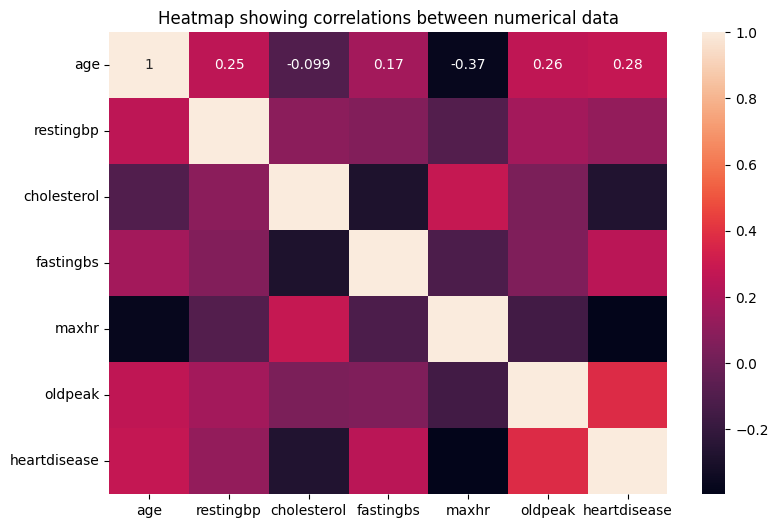

In [32]:
plt.figure(figsize=(9, 6))
sns.heatmap(data_numeric.corr(), annot=True)
plt.title('Heatmap showing correlations between numerical data')
plt.show();

# One Hot Encoding

In [33]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# Logistic Regression

In [34]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train,y_train)

C:\Users\mulin\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [35]:
y_pred = model.predict_proba(X_val)[:, 1]

In [36]:
heartdisease_decision = (y_pred >= 0.5)

In [37]:
(y_val == heartdisease_decision).mean()

0.842391304347826

In [38]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = heartdisease_decision.astype(int)
df_pred['actual'] = y_val
df_pred

,probability,prediction,actual
0,0.922061,1,1
1,0.955817,1,0
2,0.876493,1,1
3,0.577492,1,1
4,0.898983,1,1
...,...,...,...
179,0.540991,1,0
180,0.988224,1,1
181,0.956804,1,1
182,0.276619,0,0


In [39]:
roc_auc_score(y_val, y_pred)

0.908875177978168

# Cross Validation

In [40]:
df_full_train, df_test = train_test_split(raw_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.heartdisease .values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

del df_train['heartdisease']
del df_val['heartdisease']
del df_test['heartdisease']

In [41]:
def train(df_train, y_train, C=1.0):
    x_dict = df_train.to_dict(orient='records')
    dv= DictVectorizer(sparse=False)
    x_train = dv.fit_transform(x_dict)
    
    model = LogisticRegression(C=C,max_iter=1000)
    model.fit(x_train,y_train)
    
    return dv,model

In [42]:
def predict(df_val,dv,model):
    x_dict = df_val.to_dict(orient='records')
    x_val  = dv.transform(x_dict)
    y_pred = model.predict_proba(x_val)[:,1]
    return y_pred

In [43]:
n_splits = 5

for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.heartdisease.values
        y_val = df_val.heartdisease.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001 0.824 +- 0.027
C=0.01 0.958 +- 0.018
C=0.1 1.000 +- 0.000
C=0.5 1.000 +- 0.000
C=1 1.000 +- 0.000


C:\Users\mulin\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mulin\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

C=5 1.000 +- 0.000


C:\Users\mulin\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\mulin\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

C=10 1.000 +- 0.000


C:\Users\mulin\anaconda3\envs\ml-zoomcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
df_train

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
852,43,M,ASY,120,177,0,LVH,120,Y,2.5,Flat,1
121,52,F,NAP,125,272,0,Normal,139,N,0.0,Up,0
664,65,F,ASY,150,225,0,LVH,114,N,1.0,Flat,1
187,41,M,ASY,120,237,1,Normal,138,Y,1.0,Flat,1
108,50,M,ASY,140,129,0,Normal,135,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
767,54,F,NAP,108,267,0,LVH,167,N,0.0,Up,0
72,52,M,ASY,120,182,0,Normal,150,N,0.0,Flat,1
908,63,M,ASY,140,187,0,LVH,144,Y,4.0,Up,1
235,39,M,ATA,120,200,0,Normal,160,Y,1.0,Flat,0


# Decision Tree 

In [46]:
df_full_train, df_test = train_test_split(raw_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.heartdisease .values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

del df_train['heartdisease']
del df_val['heartdisease']
del df_test['heartdisease']

In [47]:
scores = []
depths = [4,5,6]

for depth in depths: 
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        x_dict = df_train.to_dict(orient='records')
        dv= DictVectorizer(sparse=False)
        x_train = dv.fit_transform(x_dict)
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(x_train, y_train)
        val_dicts = df_val.to_dict(orient='records')
        x_val = dv.transform(val_dicts)
        y_pred = dt.predict_proba(x_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, s, auc))

In [48]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [49]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.863  0.866  0.850
5                 0.879  0.884  0.878
10                0.876  0.874  0.886
15                0.874  0.880  0.881
20                0.872  0.872  0.868
100               0.801  0.801  0.801
200               0.742  0.742  0.742
500               0.500  0.500  0.500

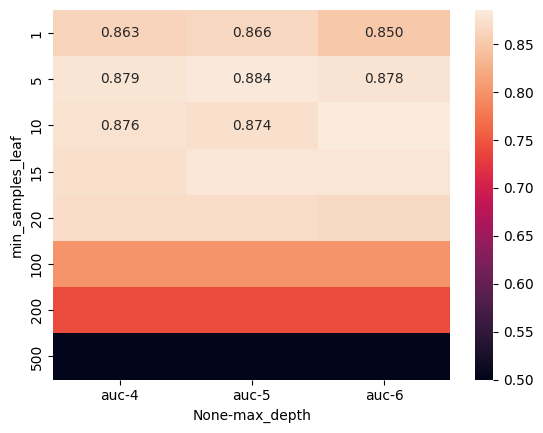

In [50]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f");

In [69]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

In [70]:
val_dicts = df_val.to_dict(orient='records')
x_val = dv.transform(val_dicts)
y_pred = dt.predict_proba(x_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.8747626957759848

# Random Forest Classifier

In [72]:
df_full_train, df_test = train_test_split(raw_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.heartdisease .values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

del df_train['heartdisease']
del df_val['heartdisease']
del df_test['heartdisease']

In [73]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [74]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [75]:
df_scores_pivot = df_scores.pivot(index='n_estimators', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth        5      10     15
n_estimators                     
10            0.897  0.879  0.891
20            0.895  0.887  0.906
30            0.901  0.900  0.908
40            0.901  0.903  0.908
50            0.905  0.907  0.910
60            0.905  0.910  0.909
70            0.905  0.908  0.911
80            0.906  0.908  0.910
90            0.906  0.909  0.912
100           0.908  0.910  0.911
110           0.907  0.910  0.911
120           0.906  0.909  0.910
130           0.906  0.911  0.910
140           0.906  0.910  0.909
150           0.906  0.910  0.910
160           0.906  0.911  0.910
170           0.906  0.910  0.910
180           0.907  0.910  0.909
190           0.906  0.911  0.910
200           0.906  0.910  0.912

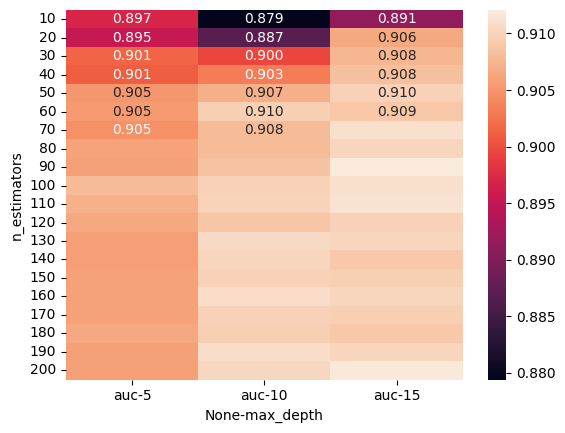

In [76]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f");

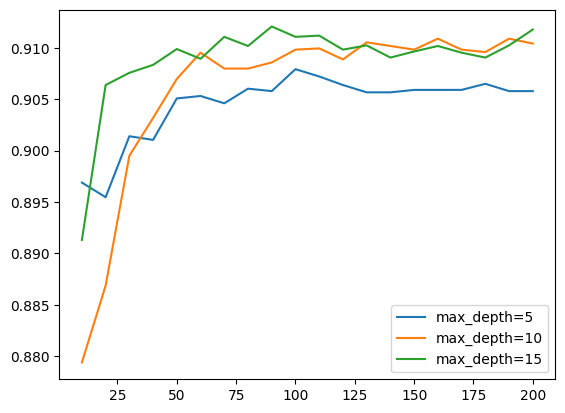

In [77]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend();

In [58]:
max_depth = 15

In [59]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [60]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

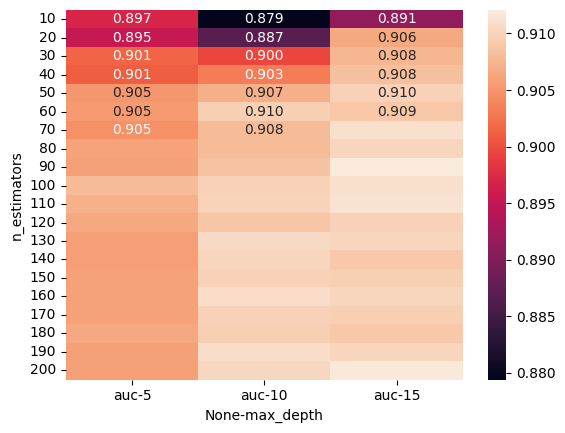

In [61]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f");

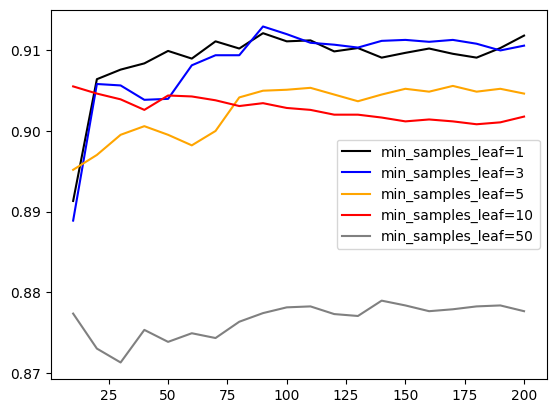

In [62]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend();

In [63]:
min_samples_leaf = 3

In [64]:
scores = []
for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [65]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [66]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,random_state=1)

rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [67]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc

0.9105363075462743

# Gradient boosting and XGBoost

In [78]:
df_full_train, df_test = train_test_split(raw_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.heartdisease .values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

del df_train['heartdisease']
del df_val['heartdisease']
del df_test['heartdisease']

In [79]:
x_dict = df_train.to_dict(orient='records')
dv= DictVectorizer(sparse=False)
x_train = dv.fit_transform(x_dict)
val_dicts = df_val.to_dict(orient='records')
x_val = dv.transform(val_dicts)

In [85]:
features = dv.get_feature_names_out()
features

array(['age', 'chestpaintype=ASY', 'chestpaintype=ATA',
       'chestpaintype=NAP', 'chestpaintype=TA', 'cholesterol',
       'exerciseangina=N', 'exerciseangina=Y', 'fastingbs', 'maxhr',
       'oldpeak', 'restingbp', 'restingecg=LVH', 'restingecg=Normal',
       'restingecg=ST', 'sex=F', 'sex=M', 'st_slope=Down',
       'st_slope=Flat', 'st_slope=Up'], dtype=object)

In [87]:
features = dv.get_feature_names_out()
features = features.tolist()
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=features)

In [91]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8970099667774085

In [92]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [101]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10,
                  verbose_eval=5,
                  evals=watchlist)
y_pred = model.predict(dval)

In [102]:
roc_auc_score(y_val, y_pred)

0.8970099667774085

In [94]:
s = output.stdout

In [107]:
print(s[:200])

[0]	train-auc:0.95102	val-auc:0.87631
[5]	train-auc:0.98991	val-auc:0.88805
[10]	train-auc:0.99643	val-auc:0.89440
[15]	train-auc:0.99880	val-auc:0.89565
[20]	train-auc:0.99977	val-auc:0.89511
[25]	tr


In [115]:
def parse(output):
    scores = []
    for line in output.stdout.strip().split('\n'):
            a,b,c = line.split('\t')
            itr = int(a.strip('[]'))
            train = float(b.split(':')[1])
            val = float(c.split(':')[1])
            
            scores.append((itr,train,val))
    columns = ['iteration','train_auc','val_auc']
    df_scores = pd.DataFrame(scores,columns=columns)
    return df_scores

In [116]:
df_score = parse(output)

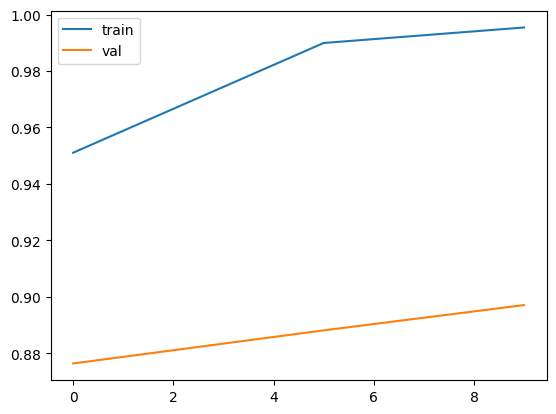

In [119]:
plt.plot(df_score.iteration, df_score.train_auc, label='train')
plt.plot(df_score.iteration, df_score.val_auc, label='val')
plt.legend();